# Classification Activity of Inhibitors of EphA4 Receptor Antagonists (AID 689) with CatBoost


*The EphA4 receptor(ephrin type-A receptor 4) plays a critical role  in the inhibition of axon regeneration that occurs after spinal cord injury. Besides ,there is a correlation between EphA4 and the neurodegenerative disease Amyotrophic lateral sclerosis (ALS).*


> The assay is based on the binding of EphA4 to a peptide (KYL peptide) that interacts with the high affinity ephrin-binding site of EphA4. The goal is to find small molecules that inhibit this interaction.[1]




# Results

- Matthews Correlation Coefficient(MCC) : 0.782315

# References

- [1] National Center for Biotechnology Information (2023). PubChem Bioassay Record for AID 689, Colorimetric assay for HTS discovery of chemical inhibitors of EphA4 receptor antagonists, Source: Burnham Center for Chemical Genomics. Retrieved August 13, 2023 from https://pubchem.ncbi.nlm.nih.gov/bioassay/689.



In [1]:
!pip install catboost

In [2]:
# importing dependencies

import pandas as pd
import numpy as np
import seaborn as sns
from catboost import CatBoostClassifier, cv, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import RandomOverSampler


In [3]:
# reading and cleaning the dataset

df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GeneralDB/AID_689_datatable.csv')
df.drop([0,1,2,3], axis = 0, inplace = True)

df.drop([ 'PUBCHEM_ACTIVITY_SCORE', 'PUBCHEM_ASSAYDATA_COMMENT', 'PUBCHEM_ACTIVITY_URL', 'IC50_Qualifier','IC50',
          'Std.Err(IC50)','PUBCHEM_SID', 'PUBCHEM_CID', 'nH','PUBCHEM_RESULT_TAG','PUBCHEM_EXT_DATASOURCE_SMILES'], axis = 1 , inplace = True)


<ipython-input-3-e3403aa5d092>:3: DtypeWarning: Columns (0,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GeneralDB/AID_689_datatable.csv')


In [4]:
df.head()

,PUBCHEM_ACTIVITY_OUTCOME,%Inhibition at 10 uM,Mean High,STD Deviation High,Mean Low,STD Deviation Low
4,Inactive,39.3,0.7235,0.034592,0.053667,0.0083825
5,Inactive,39,0.61563,0.03884,0.036667,0.0043205
6,Inactive,38.9,0.74975,0.050264,0.041167,0.012271
7,Inactive,38.9,0.68775,0.012848,0.0485,0.0059245
8,Inactive,38.4,0.675,0.013887,0.045333,0.0081404


In [5]:
# classes distribution

df['PUBCHEM_ACTIVITY_OUTCOME'].value_counts()

Inactive    61728
Active         80
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

In [6]:
# converting a few column data types
# labels encodeing with 1 active, 0 non-active



df[['%Inhibition at 10 uM', 'Mean High','STD Deviation High','Mean Low','STD Deviation Low']] = df[[ '%Inhibition at 10 uM', 'Mean High','STD Deviation High','Mean Low','STD Deviation Low']].apply(pd.to_numeric)

df['PUBCHEM_ACTIVITY_OUTCOME_'] = df['PUBCHEM_ACTIVITY_OUTCOME'].apply(lambda x: 1 if x =='Active' else 0)

y = df['PUBCHEM_ACTIVITY_OUTCOME_']
X = df.drop(['PUBCHEM_ACTIVITY_OUTCOME','PUBCHEM_ACTIVITY_OUTCOME_'], axis =1)

In [7]:
# train-test splitting


RANDOM_SEED = 20

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,
                                                    stratify = y,
                                                    random_state = RANDOM_SEED,
                                                    shuffle = True)


# oversampling in training data

ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [8]:
# creating the model and training
# the model tuned with optuna

model = CatBoostClassifier(iterations = 1200,
                           verbose = 200,
                           depth = 10,
                           learning_rate= 0.0160001,
                           min_child_samples = 18,
                           early_stopping_rounds=10)


model.fit(X_train, y_train)

0:	learn: 0.6397838	total: 101ms	remaining: 2m 1s
200:	learn: 0.0011883	total: 22.5s	remaining: 1m 51s
400:	learn: 0.0005129	total: 38.6s	remaining: 1m 16s
600:	learn: 0.0004340	total: 46.6s	remaining: 46.4s
800:	learn: 0.0003918	total: 56.7s	remaining: 28.3s
1000:	learn: 0.0003917	total: 1m 4s	remaining: 12.9s
1199:	learn: 0.0003917	total: 1m 12s	remaining: 0us


In [9]:
# predicting and calculating some classification metrics

pred = model.predict(X_test)

report = classification_report(y_test, pred)
matthews_Coef = matthews_corrcoef(y_test, pred)

print("matthews_Coef :" + str(matthews_Coef))
print(report)

matthews_Coef :0.7823158539517782
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12346
           1       0.70      0.88      0.78        16

    accuracy                           1.00     12362
   macro avg       0.85      0.94      0.89     12362
weighted avg       1.00      1.00      1.00     12362



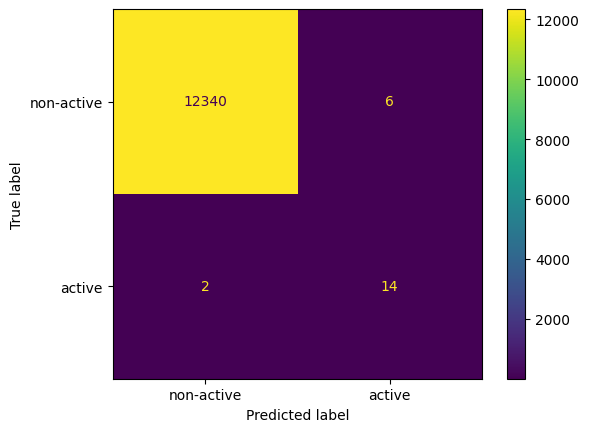

In [10]:
# plotting confusion matrix

cm = confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(cm, display_labels=['non-active','active'])
disp.plot()